
# Final Project Submission

Please fill out:
* Student name: Thomas Hill & Jonathan Vasquez
* Student pace: Full Time
* Scheduled project review date/time: 07/31/2020
* Instructor name: Fangfang Lee
* Blog post URL:


# Importing Libraries / Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt #Ploting charts
from glob import glob #retriving an array of files in directories
import shutil

import tensorflow as tf
import cv2
from sklearn.metrics import confusion_matrix, f1_score, classification_report
np.random.seed(123)

import keras
from keras import models
from keras import layers

from keras.models import load_model, Sequential #for neural network models
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator #Data augmentation and preprocessing
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.utils import to_categorical #For One-hot Encoding
from keras.optimizers import Adam, SGD, RMSprop #For Optimizing the Neural Network
from keras.callbacks import EarlyStopping

#bokeh
from bokeh.models import ColumnDataSource, HoverTool, Panel, FactorRange
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.palettes import Spectral6

import warnings
warnings.filterwarnings('ignore')

import os

In [84]:
print(os.listdir("../Mod_4_Final_Project/"))

['.DS_Store', 'Test', 'working notebook.ipynb', 'chest_xray', 'README.md', '.gitignore', 'Train', '.ipynb_checkpoints', 'sandbox.ipynb', 'Data_Visualization.ipynb', '.git', 'Validation', 'working notebook-Copy1.ipynb']


# Loading Data

In [14]:
# setup file structure
train_dir = "Train/"
test_dir = "Test/"
val_dir = "Validation/"

In [63]:
# image preprocessing
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True,
                                   rotation_range = 30
                                  )
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (64, 64), 
                                                 batch_size = 32, 
                                                 class_mode = "binary")
validation_generator = val_datagen.flow_from_directory(val_dir,
                                          target_size = (64, 64),
                                          batch_size = 32,
                                          class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 4684 images belonging to 2 classes.
Found 587 images belonging to 2 classes.
Found 585 images belonging to 2 classes.


# VGG16 Model

In [75]:
#This is a Convolutional Artificial Neural Network
#VGG16 Model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(64,64,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [76]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_52 (ZeroPaddi (None, 66, 66, 3)         0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
zero_padding2d_53 (ZeroPaddi (None, 66, 66, 64)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
zero_padding2d_54 (ZeroPaddi (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 32, 32, 128)      

In [77]:
optimizer = Adam(lr = 0.0001)
early_stopping_monitor = EarlyStopping(patience = 3, monitor = "val_accuracy", mode="max", verbose = 1)
model.compile(loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), 
                                                   tf.keras.metrics.Recall(name='recall')], optimizer=optimizer)
history = model.fit(training_set, epochs=50, callbacks=[early_stopping_monitor], shuffle=True, 
                              validation_data=validation_generator, steps_per_epoch=None, verbose=1)
prediction = model.predict(training_set, verbose=1, steps=None)

Epoch 1/50
147/147 [==============================] - 226s 2s/step - loss: 0.5632 - accuracy: 0.7265 - precision: 0.7296 - recall: 0.9933 - val_loss: 0.4686 - val_accuracy: 0.7291 - val_precision: 0.7291 - val_recall: 1.0000
Epoch 2/50
147/147 [==============================] - 226s 2s/step - loss: 0.4186 - accuracy: 0.7980 - precision: 0.8263 - recall: 0.9157 - val_loss: 0.3577 - val_accuracy: 0.8569 - val_precision: 0.8454 - val_recall: 0.9836
Epoch 3/50
147/147 [==============================] - 225s 2s/step - loss: 0.3049 - accuracy: 0.8678 - precision: 0.8997 - recall: 0.9216 - val_loss: 0.2915 - val_accuracy: 0.8927 - val_precision: 0.9176 - val_recall: 0.9369
Epoch 4/50
147/147 [==============================] - 225s 2s/step - loss: 0.2390 - accuracy: 0.9037 - precision: 0.9370 - recall: 0.9307 - val_loss: 0.4134 - val_accuracy: 0.7939 - val_precision: 0.9723 - val_recall: 0.7383
Epoch 5/50
147/147 [==============================] - 226s 2s/step - loss: 0.2260 - accuracy: 0.9041

In [78]:
test_accu_VGG16 = model.evaluate(test_set)

19/19 [==============================] - 7s 389ms/step - loss: 0.3332 - accuracy: 0.8479 - precision: 0.9694 - recall: 0.8173


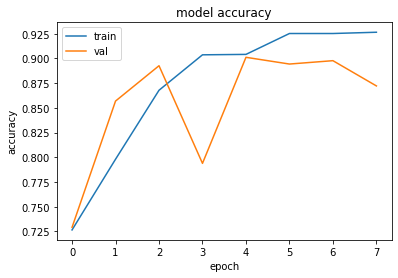

In [79]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

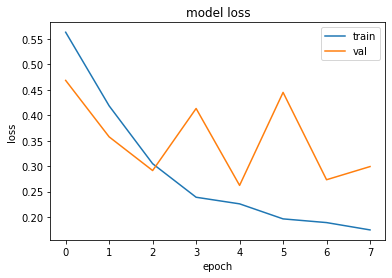

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [81]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [82]:
Y_pred_base = model.predict(test_set)
Y_pred_concat = np.concatenate(Y_pred_base)
y_pred = np.where(Y_pred_concat > 0.5, 1, 0)
confusion_matrix(test_set.classes, y_pred)

array([[ 64,  94],
       [161, 266]])

Confusion matrix, without normalization
[[ 64  94]
 [161 266]]


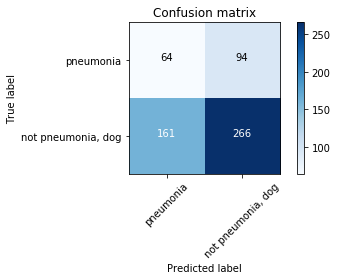

In [83]:
plt.figure()
plot_confusion_matrix(confusion_matrix(test_set.classes, y_pred), classes=['pneumonia', 'not pneumonia, dog'], normalize=False,
                      title='Confusion matrix')